## Лабораторная работа 5 - Создание классификатора
Разделы:
1. Загрузка данных
2. Предварительная обработка данных
3. Построение простой нейронной сети
5. Обучение
7. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения
6. Работа с "контрольными точками" в нейронной сети

### 0. Дополнительные библиотеки  
Одратите внимание, что для данной лабораторной работы необходимо установить 2 библиотеки
- tensorflow
- keras

In [31]:
!pip install keras
# Если вам не повезло и tensorflow последней версии не устанавливается или не хочет работать, то надо поставить версию 1.5
!pip install tensorflow==1.5

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [32]:
# подключение библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

### 1. Загрузка данных

**Обратите внимание**  
При загрузки данных мы сразу же выбираем поле для индексации, это нужно для дальнейшего разделения данныех и удаления выбросов в обоих

In [33]:
import pandas as pd

data = pd.read_csv('../../../../data/titanic_train.csv', index_col='PassengerId')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Предварительная обработка данных  

Готовим наши данные для подачи на вход нейронной сети

In [34]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)
        

У нас будет 2 pipeline'а:
1. Для входных данных
2. Для выходных

У входных и выходных данных будут общие следующие обработчики:
1. DropOutlet - наш класс для удаления выбросов
2. Конвертация из DataFrame в ndarray

*Препроцессор DropOutlet идет отдельно от всех других препроцессоров*


**Препроцессор для входных данных**:
1. Конвертация из DataFrame в ndarray
1. Нормализация с помощью препроцессора MinMaxScaler

**Препроцессор для выходных данных**:
1. Конвертация из DataFrame в ndarray
1. Преобразование из категорий в виде строк в числовой номер (1.2.3.4): ModifyLabelEncoder
1. Добавляем еще одну размерность для данных (нужно для следующего препроцессора): ExpandDims
1. Кодируем наши категории как вектор с одной 1 : OneHotEncoder  
*Вот наглядно, что делает OneHotEncoder*
![OneHotEncoder](https://3.bp.blogspot.com/-HDEv1_z3gc4/WhqyArqWc7I/AAAAAAAADjI/u9K8OrCY7TcLrNFDOuSQPeClCAv2jRv2wCLcBGAs/s1600/Screen%2BShot%2B2560-11-26%2Bat%2B7.21.59%2BPM.png)

У pipeline обектов есть 3 метода:
- fit - тренирует обект. Тут происходит запоминание особенностей данных (если они нужны)
- transform - непосредственное преобразование данных
- fit_transform - в начале тренирует, а потом преобразует

In [35]:
data = data.drop(["Name", "Ticket", "Cabin"], axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [37]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data.drop(["Survived"], axis=1).copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data.Survived.copy()
Y_data.head()
# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(751, 10) (751, 2)


In [38]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[1.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.75770122, 0.        , 0.        , 0.31457232,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.1277244 , 1.        , 0.5       , 0.12783054,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [1.        , 0.4305

Как можно видеть выше мы получили на выходе многомерный массив. именно его и мы будем в дальнейшем подавать на вход для алгоритмов машинного обучения

Для знакомства с массивами из библиотеки NumPy воспользуйтесь ссылкой http://cs231n.github.io/python-numpy-tutorial/

### 3. Построение простой нейронной сети


Для удобства работы с нейронной сеть, переопределим переменные
- number_data_ready_X теперь X_train
- number_data_ready_Y теперь Y_train

В перепенной X_train хранятся данные для тренировки сети (входные)  
В перепенной Y_train хранятся данные для тренировки сети (выходные или правильные ответы)

In [39]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((751, 10), (751, 2))

#### Подключаем библиотеку keras


```Python
from keras.layers import Dense
```
Строка отвечает за подключение сущности Dense которая реализует простой полносвязные слой сети (FFN)

```Python
from keras.models import Sequential
```
Строка отвечает за подключение сущности Sequential которая реализует саму нейронную сеть

```Python
from keras import activations
```
Это импорт (activations) содержи в себе список функций активании для сети

```Python
from keras.optimizers import Adam, RMSprop
```
Тут мы подключаем алгоритмы тренировки Адам и алгоритм обратного распостранения ошибки(RMSprop)

```Python
from keras.losses import categorical_crossentropy
```
Подключаем фукцию подсчета ошибки сети (кросэтропися для данных представленных в виде категорий)

```Python
from keras.metrics import categorical_accuracy
```
Подключаем фукцию подсчета метрики сети (точность попадания в категорию)


In [40]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

#### Создаем сеть
```Python
model = Sequential()
```
Создаем сущность сети

```Python
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
```
Добавляем слой сети из 10 нейронов с функцией активации Relu и количеством входом равным количеству столбцов во входном массиве

```Python
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3
```
Добавляем последний слой(выходной) количество нейронов равно количеству столбцов в выходном массиве и функцией активации Softmax 

```Python
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
```
Компилируем (собираем) сеть с параметрами:
- алгоритм обучения: *Adam*
- Функция обибки: *categorical_crossentropy*
- дополнительные метрики:
    - categorical_accuracy


In [41]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1])) # input_dim = 10
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 2

model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

### 4. Обучение

Запускаем оучение сети с параметрами:
- 1 параметр: матрица с входным массивом
- 2 параметр: матрица с требуемыми ответами (выходная матрица)
- verbose=2 : устанавливаем уровень вывода отладочной информации на 2 уровень
- epochs=100 : задаем количество эпох для обучения (100 для начала более чем достаточно)
- batch_size=3 : размер группы для обучения (пакетный метод), гду говоря как часто пересчитывать веса сети (влияет на скорость и что более важно на качество обучения (параметр подбирается опытным путем) )

In [44]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 2s - loss: 0.5784 - categorical_accuracy: 0.7390
Epoch 2/100
 - 0s - loss: 0.4905 - categorical_accuracy: 0.7989
Epoch 3/100
 - 0s - loss: 0.4700 - categorical_accuracy: 0.7856
Epoch 4/100
 - 0s - loss: 0.4615 - categorical_accuracy: 0.7856
Epoch 5/100
 - 0s - loss: 0.4572 - categorical_accuracy: 0.7870
Epoch 6/100
 - 0s - loss: 0.4544 - categorical_accuracy: 0.7896
Epoch 7/100
 - 0s - loss: 0.4500 - categorical_accuracy: 0.7870
Epoch 8/100
 - 0s - loss: 0.4492 - categorical_accuracy: 0.7949
Epoch 9/100
 - 0s - loss: 0.4453 - categorical_accuracy: 0.7923
Epoch 10/100
 - 0s - loss: 0.4473 - categorical_accuracy: 0.7989
Epoch 11/100
 - 0s - loss: 0.4448 - categorical_accuracy: 0.7909
Epoch 12/100
 - 0s - loss: 0.4439 - categorical_accuracy: 0.7936
Epoch 13/100
 - 0s - loss: 0.4428 - categorical_accuracy: 0.8016
Epoch 14/100
 - 0s - loss: 0.4416 - categorical_accuracy: 0.7936
Epoch 15/100
 - 0s - loss: 0.4396 - categorical_accuracy: 0.7976
Epoch 16/100
 - 0s - loss: 0.4372 

Посчитаем точность сети (1 цифра показывает ошибку сети, 2 метрику (точность) )

In [45]:
model.evaluate(X_train, Y_train)

751/751 [==============================] - 0s 53us/step


[0.40337557664088974, 0.8282290282008175]

### 5. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения

In [46]:
# Подключим новые библиотеки
# библиотека дополнительных возможностей (действий) при обучении сети
from keras import callbacks

#### Разделение на обучающую и тестовую выборки
Для полноценной оценки работы сети ее надо оценивать не только на тренировочной выборе (это наш 1 вариант сети), но и на тестовой (это та выборка которая никогда не подавалась на нейронную сеть)

In [47]:
# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 751
Тренировочных данных: 601
Тестовых данных: 150
Размер данные для тренировки (входных): (601, 10)
Размер данные для тренировки (выходных): (601, 2)
Размер данные для теста (входных): (150, 10)
Размер данные для теста (выходных): (150, 2)


#### Именим способ создания сети

В работе библиотеки *keras* есть одна особенность  
**Запуская метод *fit* 2 и более раз вы будете обучать всегда одну и туже сеть**

Поэтому мы обернем создание сети в метод для того что бы при каждом вызове метода fit создавалась новая сеть

In [48]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

В обучение модели добавим проверку на тестовых данных, так же добавим наш первый callback - *History*: он просто сохраняет историю измерения ошибки и метрик по эпохам

In [49]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 0s 666us/step - loss: 0.5668 - categorical_accuracy: 0.7304 - val_loss: 0.5148 - val_categorical_accuracy: 0.8000
Epoch 2/100
601/601 [==============================] - 0s 444us/step - loss: 0.4985 - categorical_accuracy: 0.7903 - val_loss: 0.4719 - val_categorical_accuracy: 0.8067
Epoch 3/100
601/601 [==============================] - 0s 458us/step - loss: 0.4761 - categorical_accuracy: 0.7903 - val_loss: 0.4571 - val_categorical_accuracy: 0.8067
Epoch 4/100
601/601 [==============================] - 0s 436us/step - loss: 0.4682 - categorical_accuracy: 0.7870 - val_loss: 0.4548 - val_categorical_accuracy: 0.8067
Epoch 5/100
601/601 [==============================] - 0s 448us/step - loss: 0.4621 - categorical_accuracy: 0.7854 - val_loss: 0.4550 - val_categorical_accuracy: 0.8067
Epoch 6/100
601/601 [==============================] - 0s 421us/step - loss: 0.4606 - 

601/601 [==============================] - 0s 652us/step - loss: 0.4134 - categorical_accuracy: 0.8087 - val_loss: 0.4441 - val_categorical_accuracy: 0.8333
Epoch 49/100
601/601 [==============================] - 0s 622us/step - loss: 0.4121 - categorical_accuracy: 0.8087 - val_loss: 0.4426 - val_categorical_accuracy: 0.8400
Epoch 50/100
601/601 [==============================] - 0s 478us/step - loss: 0.4124 - categorical_accuracy: 0.8070 - val_loss: 0.4436 - val_categorical_accuracy: 0.8400
Epoch 51/100
601/601 [==============================] - 0s 448us/step - loss: 0.4118 - categorical_accuracy: 0.8153 - val_loss: 0.4440 - val_categorical_accuracy: 0.8400
Epoch 52/100
601/601 [==============================] - 0s 443us/step - loss: 0.4118 - categorical_accuracy: 0.8136 - val_loss: 0.4430 - val_categorical_accuracy: 0.8400
Epoch 53/100
601/601 [==============================] - 0s 434us/step - loss: 0.4115 - categorical_accuracy: 0.8170 - val_loss: 0.4439 - val_categorical_accuracy: 

601/601 [==============================] - 0s 534us/step - loss: 0.4008 - categorical_accuracy: 0.8253 - val_loss: 0.4429 - val_categorical_accuracy: 0.8267
Epoch 97/100
601/601 [==============================] - 0s 503us/step - loss: 0.4011 - categorical_accuracy: 0.8220 - val_loss: 0.4457 - val_categorical_accuracy: 0.8267
Epoch 98/100
601/601 [==============================] - 0s 403us/step - loss: 0.3975 - categorical_accuracy: 0.8236 - val_loss: 0.4429 - val_categorical_accuracy: 0.8200
Epoch 99/100
601/601 [==============================] - 0s 406us/step - loss: 0.4014 - categorical_accuracy: 0.8120 - val_loss: 0.4444 - val_categorical_accuracy: 0.8200
Epoch 100/100
601/601 [==============================] - 0s 404us/step - loss: 0.3990 - categorical_accuracy: 0.8220 - val_loss: 0.4445 - val_categorical_accuracy: 0.8200


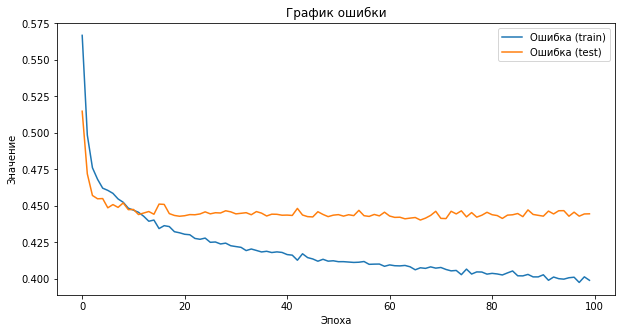

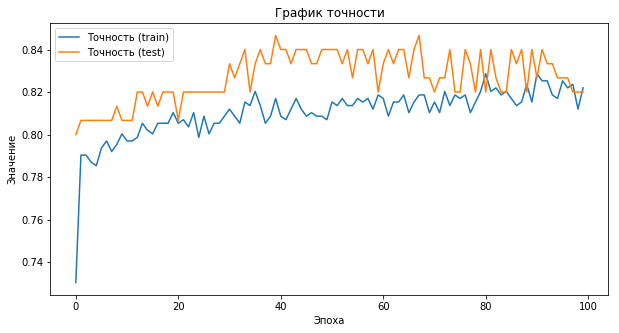

In [50]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

На самом деле в *keras* все готово для разделения данных на тренировочные и тестовые

In [51]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 1s 863us/step - loss: 0.5739 - categorical_accuracy: 0.7700 - val_loss: 0.5194 - val_categorical_accuracy: 0.8278
Epoch 2/100
600/600 [==============================] - 0s 590us/step - loss: 0.5277 - categorical_accuracy: 0.7700 - val_loss: 0.4798 - val_categorical_accuracy: 0.8146
Epoch 3/100
600/600 [==============================] - 0s 447us/step - loss: 0.5042 - categorical_accuracy: 0.7783 - val_loss: 0.4562 - val_categorical_accuracy: 0.8146
Epoch 4/100
600/600 [==============================] - 0s 445us/step - loss: 0.4882 - categorical_accuracy: 0.7783 - val_loss: 0.4421 - val_categorical_accuracy: 0.8146
Epoch 5/100
600/600 [==============================] - 0s 450us/step - loss: 0.4792 - categorical_accuracy: 0.7783 - val_loss: 0.4310 - val_categorical_accuracy: 0.8146
Epoch 6/100
600/600 [==============================] - 0s 523us/step - loss: 0.4729 - 

Epoch 49/100
600/600 [==============================] - 0s 438us/step - loss: 0.4340 - categorical_accuracy: 0.8000 - val_loss: 0.3752 - val_categorical_accuracy: 0.8609
Epoch 50/100
600/600 [==============================] - 0s 403us/step - loss: 0.4332 - categorical_accuracy: 0.8000 - val_loss: 0.3746 - val_categorical_accuracy: 0.8609
Epoch 51/100
600/600 [==============================] - 0s 397us/step - loss: 0.4326 - categorical_accuracy: 0.8000 - val_loss: 0.3748 - val_categorical_accuracy: 0.8609
Epoch 52/100
600/600 [==============================] - 0s 418us/step - loss: 0.4325 - categorical_accuracy: 0.8033 - val_loss: 0.3751 - val_categorical_accuracy: 0.8543
Epoch 53/100
600/600 [==============================] - 0s 407us/step - loss: 0.4327 - categorical_accuracy: 0.7983 - val_loss: 0.3749 - val_categorical_accuracy: 0.8543
Epoch 54/100
600/600 [==============================] - 0s 407us/step - loss: 0.4331 - categorical_accuracy: 0.8083 - val_loss: 0.3781 - val_categoric

600/600 [==============================] - 0s 430us/step - loss: 0.4243 - categorical_accuracy: 0.8017 - val_loss: 0.3698 - val_categorical_accuracy: 0.8609
Epoch 98/100
600/600 [==============================] - 0s 400us/step - loss: 0.4249 - categorical_accuracy: 0.8067 - val_loss: 0.3699 - val_categorical_accuracy: 0.8609
Epoch 99/100
600/600 [==============================] - 0s 420us/step - loss: 0.4235 - categorical_accuracy: 0.8017 - val_loss: 0.3732 - val_categorical_accuracy: 0.8609
Epoch 100/100
600/600 [==============================] - 0s 513us/step - loss: 0.4247 - categorical_accuracy: 0.7983 - val_loss: 0.3683 - val_categorical_accuracy: 0.8609


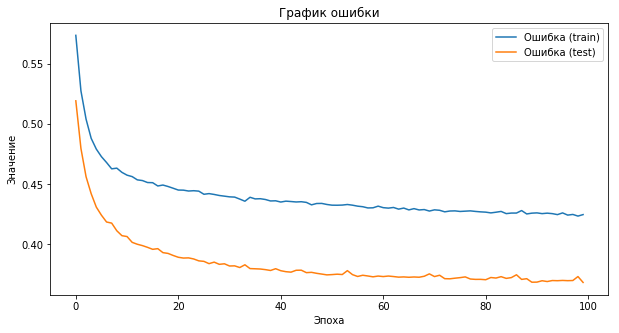

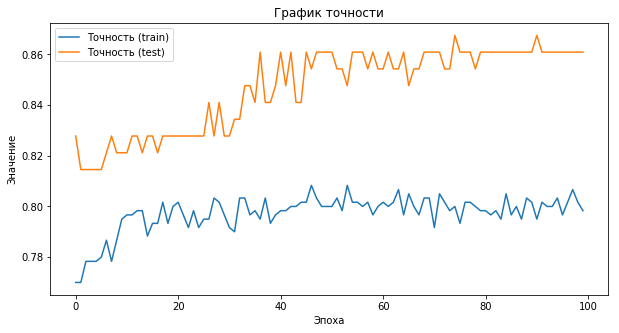

In [52]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

### Улучшение сети - Ранняя остановка
Как можно видеть на графиках выше - в какой, то момент сеть перестает улучшать свой результат и тут в лучшем случае ее надо останавливать, проблма в том, что вы не знаете заранее когда надо останавливаться (сколько нужно циклов обучения (эпох) ) 

In [53]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 0s 752us/step - loss: 0.6435 - categorical_accuracy: 0.6117 - val_loss: 0.5378 - val_categorical_accuracy: 0.7152
Epoch 2/300
600/600 [==============================] - 0s 450us/step - loss: 0.5536 - categorical_accuracy: 0.7400 - val_loss: 0.4773 - val_categorical_accuracy: 0.7947
Epoch 3/300
600/600 [==============================] - 0s 490us/step - loss: 0.5179 - categorical_accuracy: 0.7783 - val_loss: 0.4483 - val_categorical_accuracy: 0.8278
Epoch 4/300
600/600 [==============================] - 0s 450us/step - loss: 0.5011 - categorical_accuracy: 0.7833 - val_loss: 0.4334 - val_categorical_accuracy: 0.8212
Epoch 5/300
600/600 [==============================] - 0s 430us/step - loss: 0.4926 - categorical_accuracy: 0.7817 - val_loss: 0.4267 - val_categorical_accuracy: 0.8212
Epoch 6/300
600/600 [==============================] - 0s 553us/step - loss: 0.4867 - 

Epoch 49/300
600/600 [==============================] - 0s 583us/step - loss: 0.4306 - categorical_accuracy: 0.8033 - val_loss: 0.3659 - val_categorical_accuracy: 0.8609
Epoch 50/300
600/600 [==============================] - 0s 492us/step - loss: 0.4332 - categorical_accuracy: 0.8017 - val_loss: 0.3646 - val_categorical_accuracy: 0.8543
Epoch 51/300
600/600 [==============================] - 0s 607us/step - loss: 0.4328 - categorical_accuracy: 0.7950 - val_loss: 0.3668 - val_categorical_accuracy: 0.8543
Epoch 52/300
600/600 [==============================] - 0s 703us/step - loss: 0.4306 - categorical_accuracy: 0.8050 - val_loss: 0.3639 - val_categorical_accuracy: 0.8742
Epoch 53/300
600/600 [==============================] - 0s 677us/step - loss: 0.4298 - categorical_accuracy: 0.8000 - val_loss: 0.3642 - val_categorical_accuracy: 0.8609
Epoch 54/300
600/600 [==============================] - 0s 592us/step - loss: 0.4312 - categorical_accuracy: 0.8067 - val_loss: 0.3649 - val_categoric

600/600 [==============================] - 0s 427us/step - loss: 0.4216 - categorical_accuracy: 0.8183 - val_loss: 0.3592 - val_categorical_accuracy: 0.8808
Epoch 98/300
600/600 [==============================] - 0s 415us/step - loss: 0.4203 - categorical_accuracy: 0.8167 - val_loss: 0.3632 - val_categorical_accuracy: 0.8543
Epoch 99/300
600/600 [==============================] - 0s 403us/step - loss: 0.4213 - categorical_accuracy: 0.8100 - val_loss: 0.3597 - val_categorical_accuracy: 0.8742
Epoch 100/300
600/600 [==============================] - 0s 422us/step - loss: 0.4206 - categorical_accuracy: 0.8133 - val_loss: 0.3609 - val_categorical_accuracy: 0.8675
Epoch 101/300
600/600 [==============================] - 0s 410us/step - loss: 0.4203 - categorical_accuracy: 0.8100 - val_loss: 0.3595 - val_categorical_accuracy: 0.8742
Epoch 102/300
600/600 [==============================] - 0s 398us/step - loss: 0.4209 - categorical_accuracy: 0.8150 - val_loss: 0.3593 - val_categorical_accurac

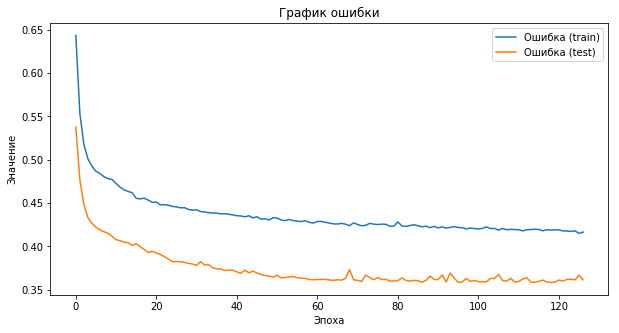

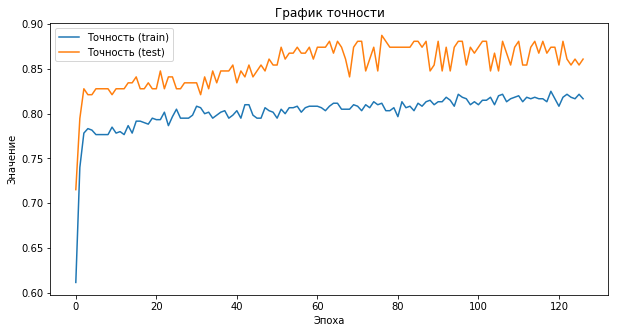

In [54]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

### 6. Контрольные точки
В обучении НС самый последний результат обучения не всегда самый лучший результат, это вызвано несколькими причинами, например переобучением сети или скатыванию к среднему значению.  
Для того что бы поймать тот самый лучший результат обучения, были придуманы "контрольные точки" *ModelCheckpoint*

Для использования контрольных точек необходимо подготовить директорию, где будут хранится контрольные точки

In [55]:
from pathlib import Path
from os import remove

In [56]:
# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

    

In [57]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками D:\Bandar\Projects\AI_1\лабы_решения\1561_2\Baluev\lab 5\save_points
Train on 480 samples, validate on 121 samples
Epoch 1/300
480/480 [==============================] - 1s 1ms/step - loss: 0.6275 - categorical_accuracy: 0.6771 - val_loss: 0.5780 - val_categorical_accuracy: 0.6777
Epoch 2/300
480/480 [==============================] - 0s 450us/step - loss: 0.5603 - categorical_accuracy: 0.7417 - val_loss: 0.5052 - val_categorical_accuracy: 0.7686
Epoch 3/300
480/480 [==============================] - 0s 683us/step - loss: 0.5205 - categorical_accuracy: 0.7750 - val_loss: 0.4645 - val_categorical_accuracy: 0.8017
Epoch 4/300
480/480 [==============================] - 0s 448us/step - loss: 0.5019 - categorical_accuracy: 0.7854 - val_loss: 0.4451 - val_categorical_accuracy: 0.8017
Epoch 5/300
480/480 [==============================] - 0s 492us/step - loss: 0.4915 - categorical_accuracy: 0.7833 - val_loss: 0.4324 - val_categoric

480/480 [==============================] - 0s 527us/step - loss: 0.4322 - categorical_accuracy: 0.8125 - val_loss: 0.3828 - val_categorical_accuracy: 0.8182
Epoch 49/300
480/480 [==============================] - 0s 717us/step - loss: 0.4322 - categorical_accuracy: 0.8104 - val_loss: 0.3819 - val_categorical_accuracy: 0.8182
Epoch 50/300
480/480 [==============================] - 0s 460us/step - loss: 0.4312 - categorical_accuracy: 0.8146 - val_loss: 0.3845 - val_categorical_accuracy: 0.8182
Epoch 51/300
480/480 [==============================] - 0s 435us/step - loss: 0.4312 - categorical_accuracy: 0.8125 - val_loss: 0.3826 - val_categorical_accuracy: 0.8017
Epoch 52/300
480/480 [==============================] - 0s 435us/step - loss: 0.4306 - categorical_accuracy: 0.8125 - val_loss: 0.3825 - val_categorical_accuracy: 0.7934
Epoch 53/300
480/480 [==============================] - 0s 425us/step - loss: 0.4303 - categorical_accuracy: 0.8167 - val_loss: 0.3817 - val_categorical_accuracy: 

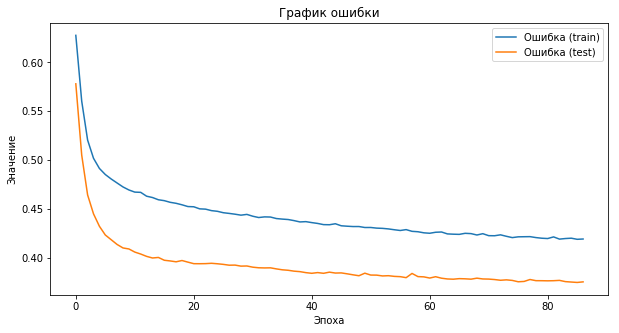

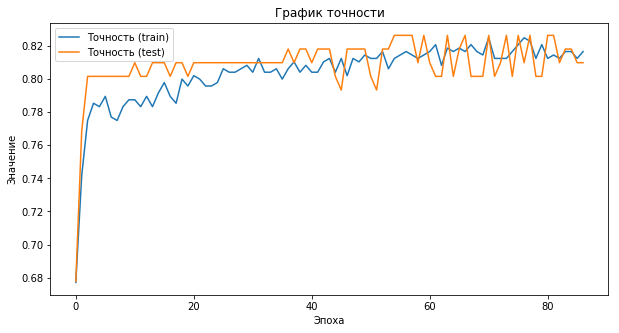

In [58]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

Воспользуемся контрольными точками

In [62]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.43_val_loss-0.38_acc-0.81_val_acc-0.83.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

601/601 [==============================] - 0s 143us/step
Точность предсказания на тренировочных данных 0.8169717143061951
150/150 [==============================] - 0s 73us/step
Точность предсказания на тестовых данных 0.8199999968210856


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

In [63]:
# Преобразуем классы в виде числа в их оригеналы
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

In [64]:
# Прдсказываем вероятности для классов
loaded_model.predict(X_train)

array([[0.8871394 , 0.11286061],
       [0.8132099 , 0.18679012],
       [0.858782  , 0.14121804],
       ...,
       [0.11494371, 0.8850563 ],
       [0.8792626 , 0.12073733],
       [0.84621346, 0.15378654]], dtype=float32)

## Бонус - визуализация наших классов
Выполнять это не обязательно

In [65]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


(751, 2)


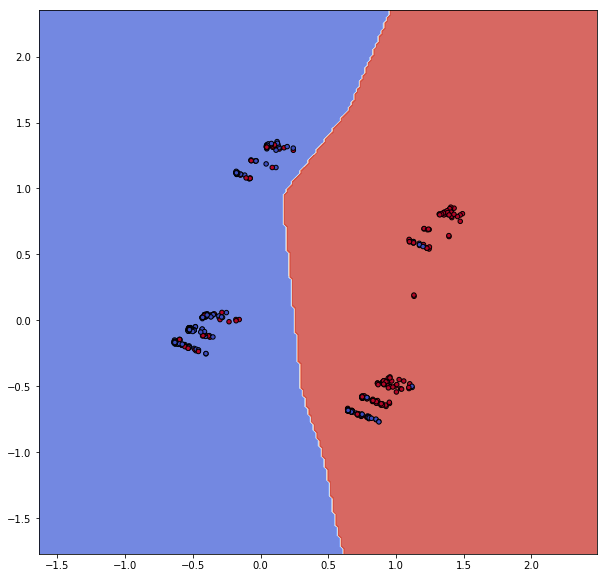

In [66]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_ready_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')